In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
# the libraries above are used to set seeds for replication purposes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from workalendar.europe import Greece
cal = Greece()
# libraries for preprocessing

import tensorflow as tf
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential,Model
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import Input,Dense,LSTM,GRU,RNN
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1
from keras.regularizers import l2
#tensorflow and keras

Using TensorFlow backend.


In [2]:
# tsextract useful library to help with data shape transformation
from tsextract.feature_extraction.extract import build_features, build_features_forecast
from tsextract.domain.statistics import mean

In [3]:
data=pd.read_excel('all_data.xlsx')
data.shape

(27024, 8)

In [4]:
def working_days(df_date): # this is used to find dates where there is a national holiday or is weekend
    if cal.is_working_day(df_date):
        return 1
    else:
        return 0
    
data.index=data.Date
data['Month'] = data.index.month
data['Holiday_weekend']=data['Date'].apply(working_days)
data=data.reset_index(drop=True)
data

,Date,Load,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki,Month,Holiday_weekend
0,2018-06-01 00:00:00,5047,21.5,2.5,30.0,19.0,1.0,66.0,6,1
1,2018-06-01 01:00:00,4696,20.0,2.0,33.0,19.0,1.0,68.0,6,1
2,2018-06-01 02:00:00,4560,19.0,2.0,36.0,19.0,1.0,64.0,6,1
3,2018-06-01 03:00:00,4482,21.0,2.5,32.0,17.0,1.5,73.0,6,1
4,2018-06-01 04:00:00,4465,20.5,1.0,34.0,16.5,1.5,75.0,6,1
...,...,...,...,...,...,...,...,...,...,...
27019,2021-06-30 19:00:00,8607,31.0,1.0,41.0,31.0,3.0,49.0,6,1
27020,2021-06-30 20:00:00,8382,31.0,0.0,43.5,30.0,3.0,57.0,6,1
27021,2021-06-30 21:00:00,8479,30.0,1.0,42.0,29.5,2.5,62.5,6,1
27022,2021-06-30 22:00:00,8216,29.5,3.0,37.0,28.0,2.0,66.0,6,1


In [5]:
data.index=data['Date']
data=data.drop('Date',axis=1)
data.head(30)

,Load,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki,Month,Holiday_weekend
Date,,,,,,,,,
2018-06-01 00:00:00,5047,21.5,2.5,30.0,19.0,1.0,66.0,6,1
2018-06-01 01:00:00,4696,20.0,2.0,33.0,19.0,1.0,68.0,6,1
2018-06-01 02:00:00,4560,19.0,2.0,36.0,19.0,1.0,64.0,6,1
2018-06-01 03:00:00,4482,21.0,2.5,32.0,17.0,1.5,73.0,6,1
2018-06-01 04:00:00,4465,20.5,1.0,34.0,16.5,1.5,75.0,6,1
2018-06-01 05:00:00,4519,18.0,0.0,40.0,16.0,2.0,72.0,6,1
2018-06-01 06:00:00,4636,19.5,3.0,39.0,16.5,2.0,72.5,6,1
2018-06-01 07:00:00,5187,23.0,2.0,31.0,19.5,1.0,60.5,6,1
2018-06-01 08:00:00,5871,25.5,2.0,27.0,22.0,1.0,55.0,6,1


# Forecasting with Supervised Learning

Since we are going to use neural networks for forecasting we should convert our data in  **[samples, input_features] , [samples, output]** format. In our case the output is the future values of electrical load, while the input will be all past weather and calendar data along with the past electrical load values.

We first use only past values of electrical load as our input features.

In [6]:
features_request = {"window": [24]} #input size window

build_df = build_features(data['Load']
                         ,features_request, target_lag=1, include_tzero=False) # tzero (time_zero) refers to the current time

build_df
# target lag shows how many hours ahead we want to predict. In our case we choose to predict 1 value 1 hour into the future

,T-24,T-23,T-22,T-21,T-20,T-19,T-18,T-17,T-16,T-15,...,T-9,T-8,T-7,T-6,T-5,T-4,T-3,T-2,T-1,Target_Tplus1
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-02 00:00:00,5047.0,4696.0,4560.0,4482.0,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,...,6295.0,6124.0,6108.0,6129.0,6165.0,6277.0,6506.0,6053.0,5690.0,4898.0
2018-06-02 01:00:00,4696.0,4560.0,4482.0,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,6550.0,...,6124.0,6108.0,6129.0,6165.0,6277.0,6506.0,6053.0,5690.0,5246.0,4670.0
2018-06-02 02:00:00,4560.0,4482.0,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,6550.0,6778.0,...,6108.0,6129.0,6165.0,6277.0,6506.0,6053.0,5690.0,5246.0,4898.0,4528.0
2018-06-02 03:00:00,4482.0,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,6550.0,6778.0,6853.0,...,6129.0,6165.0,6277.0,6506.0,6053.0,5690.0,5246.0,4898.0,4670.0,4486.0
2018-06-02 04:00:00,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,6550.0,6778.0,6853.0,6848.0,...,6165.0,6277.0,6506.0,6053.0,5690.0,5246.0,4898.0,4670.0,4528.0,4517.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 18:00:00,8699.0,8456.0,8225.0,8216.0,7987.0,7732.0,7139.0,6603.0,6272.0,6117.0,...,8147.0,8694.0,9054.0,9433.0,9750.0,9809.0,9564.0,9362.0,9213.0,8607.0
2021-06-30 19:00:00,8456.0,8225.0,8216.0,7987.0,7732.0,7139.0,6603.0,6272.0,6117.0,5881.0,...,8694.0,9054.0,9433.0,9750.0,9809.0,9564.0,9362.0,9213.0,8968.0,8382.0
2021-06-30 20:00:00,8225.0,8216.0,7987.0,7732.0,7139.0,6603.0,6272.0,6117.0,5881.0,5826.0,...,9054.0,9433.0,9750.0,9809.0,9564.0,9362.0,9213.0,8968.0,8607.0,8479.0


Based on this dataframe we want to predict the electrical load in next hour (Target_Tplus1) based on the previous 24 hours. So every row holds past 24 hours of data and 1 hour into the future.

# Scale Data

Scale data to [0,1] range and then split to train and test sets.

In [7]:
scaler_features = MinMaxScaler().fit(build_df[build_df.columns.values[:-1]]) # input features scaler
scaled_features = scaler_features.transform(build_df[build_df.columns.values[:-1]])

scaler_label = MinMaxScaler().fit(np.array(build_df[build_df.columns.values[-1]]).reshape(-1, 1)) #output feature scaler
scaled_label = scaler_label.transform(np.array(build_df[build_df.columns.values[-1]]).reshape(-1, 1))


### Split data using train proportion of 0.7
train_size = int(scaled_features[:, :-1].shape[0] * 0.8)
x_train, y_train = scaled_features[:train_size, :-1], scaled_label[:train_size, :]
x_test, y_test = scaled_features[train_size:, :-1], scaled_label[train_size:, :]

# Feed Forward Network Model

At this stage we can build a simple feed forward network model that only uses the previous electrical load values to predict 1h into the future.

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(50, activation='relu'))
model.add(Dense(y_train.shape[1],activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2400      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 7,501
Trainable params: 7,501
Non-trainable params: 0
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 0.01024, saving model to load_model.h5

Epoch 00002: val_loss improved from 0.01024 to 0.00263, saving model to load_model.h5

Epoch 00003: val_loss improved from 0.00263 to 0.00236, saving model to load_model.h5

Epoch 00004: val_loss improved from 0.00236 to 0.00210, saving model to load_model.h5

Epoch 00005: val_loss improved from 0.00210 to 0.00205, saving model to load_model.h5

Epoch 00006: val_loss improved from 0.00205 to 0.00193, saving model to load_model.h5

Epoch 00007: val_loss improved from 0.00193 to 0.00188, saving model to load_model.h5

Epoch 00008: val_loss improved from 0.00188 to 0.00175, saving model to load_model.h5

Epoch 00009: val_loss improved from 0.00175 to 0.00169, saving model to load_model.h5

Epoch 00010: val_loss did not improve from 0.00169

Epoch 00011: val_loss improved from 0.00169 to 0.00156, saving model to load_model.h5

Epoch 00012: val_loss improved from 0.00156 to 0.00149, saving model to load_mode

<AxesSubplot:>

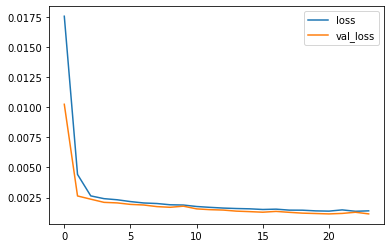

In [9]:
# batch is the number of samples that is shown to the network before a weight update is performed
# 360 here means 360 of our samples. Every new sample contains 1 extra hour.... so 360 batch means 360 new hours (15 days) before weight update

n_epochs = 1000 # don't care much about epochs since we use early stopping
batch=360
model.compile(optimizer='adam', loss='mse')
checkpointer = ModelCheckpoint(filepath="load_model.h5",
                               verbose=1,
                               save_best_only=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) # early stopping

history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=0,
                    callbacks=[checkpointer,es_callback])
df_loss = pd.DataFrame(history.history)
df_loss[['loss','val_loss']].plot()

We can see that the validation and the training loss follow the same curve. This is an indicator that the model is probably not overfitted. 

In [10]:
predictions_train = model.predict(x_train)
predictions_test = model.predict(x_test)

predictions_train = scaler_label.inverse_transform(predictions_train)
y_train=scaler_label.inverse_transform(y_train)

predictions_test = scaler_label.inverse_transform(predictions_test)
y_test=scaler_label.inverse_transform(y_test)

trainScore = math.sqrt(mean_squared_error(y_train, predictions_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, predictions_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 240.16 RMSE
Test Score: 256.00 RMSE


As expected, the Root of Mean Squared Error in the test set is slightly higher than the train set, since the test set holds data that are not "seen" by the model during training.

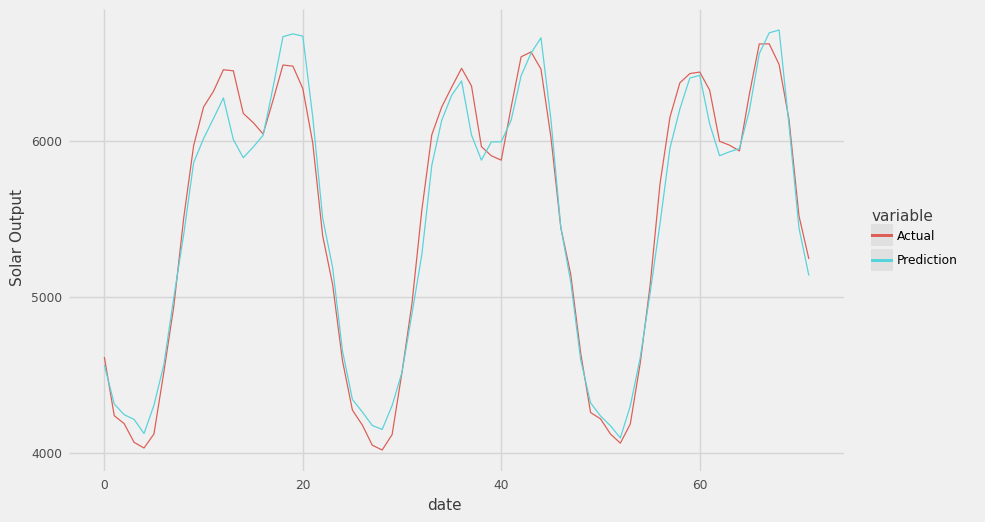

<ggplot: (110374182015)>


In [11]:
from tsextract.plots.eval import actualPred, scatter

actualPred(y_test.reshape(-1,)[:72], predictions_test.reshape(-1)[:72])

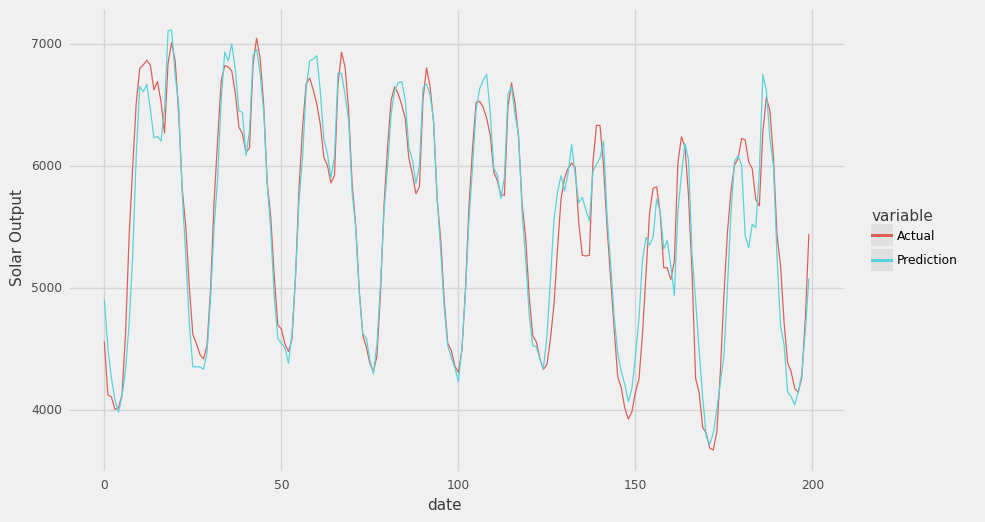

<ggplot: (-9223371926480533742)>


In [12]:
actualPred(y_test.reshape(-1,)[1800:2000], predictions_test.reshape(-1)[1800:2000])

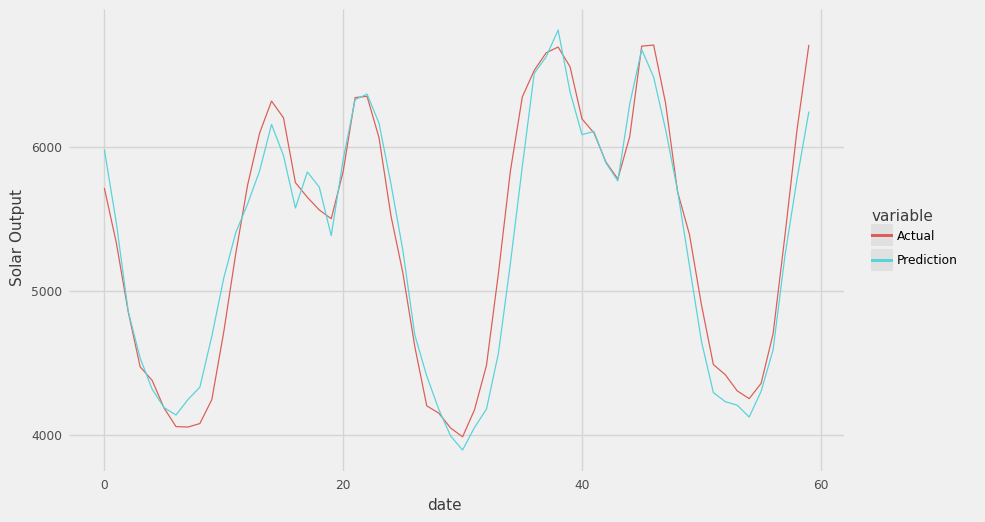

<ggplot: (110374183116)>


In [13]:
actualPred(y_test.reshape(-1,)[2950:3010], predictions_test.reshape(-1)[2950:3010])

Solely based on a simple train test split, we notice that the accuracy in our predictions is acceptable. The predicted electrical load matches the actual load and we can see that our model is able to capture the seasonality and certain peaks of the actual load curve. 

In this model though it is necesairy to have data of the last 24 hours so that we can predict a single value into the future. It is highly unlikely though, that we know the actual electrical load values in the past 24 hours (i.e. the time we choose to "hit the button" we need to know what the load consumption was 24h ago.)

To counter this issue we are going to build the same model, but try a longer horizon of 48h. With such a model, in a real case scenario we would use 24 hours of past data at most 2 days old in order to get a forecast for the next hour.

We follow the same pipeline:

In [14]:
features_request = {"window": [24]} #input size window

build_df = build_features(data['Load']
                         ,features_request, target_lag=48, include_tzero=False) # tzero (time_zero) refers to the current time
#The target lag is now 48h

build_df

,T-24,T-23,T-22,T-21,T-20,T-19,T-18,T-17,T-16,T-15,...,T-9,T-8,T-7,T-6,T-5,T-4,T-3,T-2,T-1,Target_Tplus48
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-02 00:00:00,5047.0,4696.0,4560.0,4482.0,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,...,6295.0,6124.0,6108.0,6129.0,6165.0,6277.0,6506.0,6053.0,5690.0,5031.0
2018-06-02 01:00:00,4696.0,4560.0,4482.0,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,6550.0,...,6124.0,6108.0,6129.0,6165.0,6277.0,6506.0,6053.0,5690.0,5246.0,4566.0
2018-06-02 02:00:00,4560.0,4482.0,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,6550.0,6778.0,...,6108.0,6129.0,6165.0,6277.0,6506.0,6053.0,5690.0,5246.0,4898.0,4460.0
2018-06-02 03:00:00,4482.0,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,6550.0,6778.0,6853.0,...,6129.0,6165.0,6277.0,6506.0,6053.0,5690.0,5246.0,4898.0,4670.0,4368.0
2018-06-02 04:00:00,4465.0,4519.0,4636.0,5187.0,5871.0,6257.0,6550.0,6778.0,6853.0,6848.0,...,6165.0,6277.0,6506.0,6053.0,5690.0,5246.0,4898.0,4670.0,4528.0,4317.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-28 19:00:00,7451.0,7270.0,7489.0,7467.0,7150.0,6671.0,6163.0,5835.0,5548.0,5361.0,...,8265.0,8602.0,8936.0,9245.0,9335.0,9024.0,8811.0,8627.0,8464.0,8607.0
2021-06-28 20:00:00,7270.0,7489.0,7467.0,7150.0,6671.0,6163.0,5835.0,5548.0,5361.0,5361.0,...,8602.0,8936.0,9245.0,9335.0,9024.0,8811.0,8627.0,8464.0,8270.0,8382.0
2021-06-28 21:00:00,7489.0,7467.0,7150.0,6671.0,6163.0,5835.0,5548.0,5361.0,5361.0,5519.0,...,8936.0,9245.0,9335.0,9024.0,8811.0,8627.0,8464.0,8270.0,8023.0,8479.0


In [15]:
scaler_features = MinMaxScaler().fit(build_df[build_df.columns.values[:-1]]) # input features scaler
scaled_features = scaler_features.transform(build_df[build_df.columns.values[:-1]])

scaler_label = MinMaxScaler().fit(np.array(build_df[build_df.columns.values[-1]]).reshape(-1, 1)) #output feature scaler
scaled_label = scaler_label.transform(np.array(build_df[build_df.columns.values[-1]]).reshape(-1, 1))


### Split data using train proportion of 0.7
train_size = int(scaled_features[:, :-1].shape[0] * 0.8)
x_train, y_train = scaled_features[:train_size, :-1], scaled_label[:train_size, :]
x_test, y_test = scaled_features[train_size:, :-1], scaled_label[train_size:, :]

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(50, activation='relu'))
model.add(Dense(y_train.shape[1],activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2400      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 7,501
Trainable params: 7,501
Non-trainable params: 0
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 0.01538, saving model to load_model_48h.h5

Epoch 00002: val_loss improved from 0.01538 to 0.00789, saving model to load_model_48h.h5

Epoch 00003: val_loss improved from 0.00789 to 0.00754, saving model to load_model_48h.h5

Epoch 00004: val_loss improved from 0.00754 to 0.00742, saving model to load_model_48h.h5

Epoch 00005: val_loss did not improve from 0.00742

Epoch 00006: val_loss improved from 0.00742 to 0.00738, saving model to load_model_48h.h5

Epoch 00007: val_loss did not improve from 0.00738

Epoch 00008: val_loss improved from 0.00738 to 0.00737, saving model to load_model_48h.h5

Epoch 00009: val_loss improved from 0.00737 to 0.00720, saving model to load_model_48h.h5

Epoch 00010: val_loss improved from 0.00720 to 0.00717, saving model to load_model_48h.h5

Epoch 00011: val_loss did not improve from 0.00717

Epoch 00012: val_loss did not improve from 0.00717

Epoch 00013: val_loss did not improve from 0.00717


<AxesSubplot:>

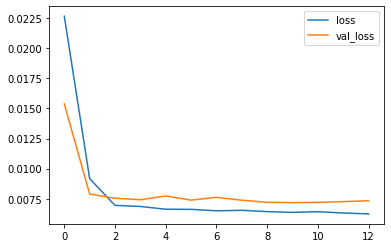

In [17]:
n_epochs = 1000 # don't care much about epochs since we use early stopping
batch=360
model.compile(optimizer='adam', loss='mse')
checkpointer = ModelCheckpoint(filepath="load_model_48h.h5",
                               verbose=1,
                               save_best_only=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) # early stopping

history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=0,
                    callbacks=[checkpointer,es_callback])
df_loss = pd.DataFrame(history.history)
df_loss[['loss','val_loss']].plot()

In [18]:
predictions_train = model.predict(x_train)
predictions_test = model.predict(x_test)

predictions_train = scaler_label.inverse_transform(predictions_train)
y_train=scaler_label.inverse_transform(y_train)

predictions_test = scaler_label.inverse_transform(predictions_test)
y_test=scaler_label.inverse_transform(y_test)

trainScore = math.sqrt(mean_squared_error(y_train, predictions_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, predictions_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 546.12 RMSE
Test Score: 565.41 RMSE


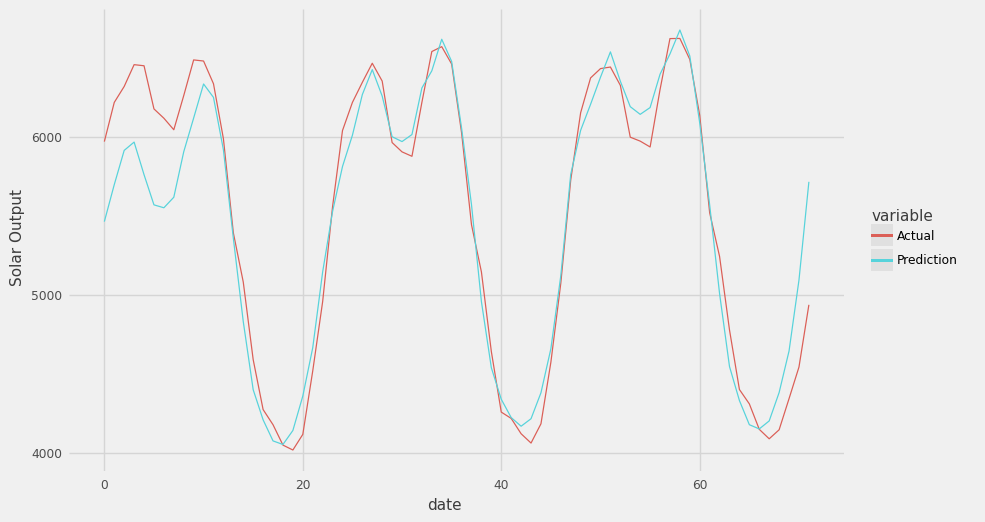

<ggplot: (-9223371926480540668)>


In [19]:
actualPred(y_test.reshape(-1,)[:72], predictions_test.reshape(-1)[:72])

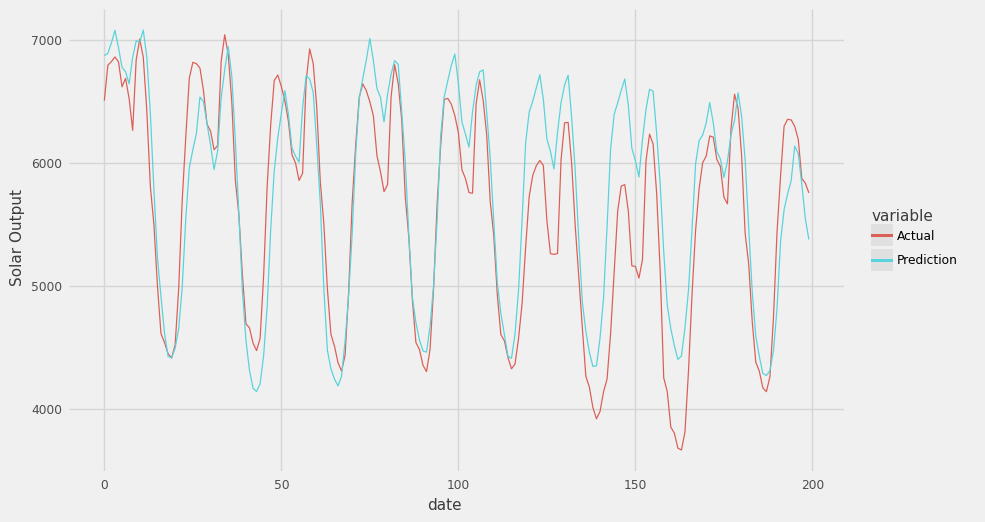

<ggplot: (110374297313)>


In [20]:
actualPred(y_test.reshape(-1,)[1800:2000], predictions_test.reshape(-1)[1800:2000])

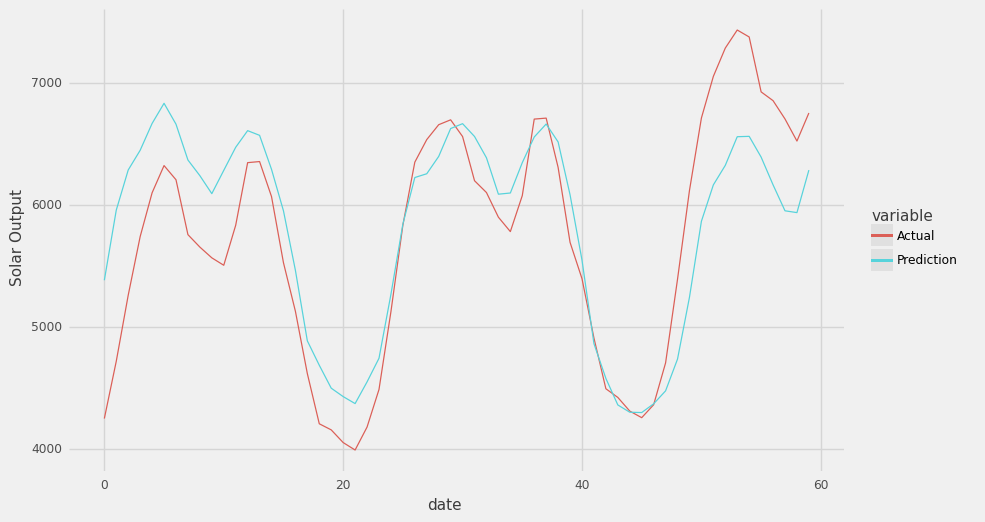

<ggplot: (-9223371926480557175)>


In [21]:
actualPred(y_test.reshape(-1,)[2950:3010], predictions_test.reshape(-1)[2950:3010])

As expected this model's accuracy is much less than the previous model. We can still see that the model has captured the electrial load seasonality, but it is not able to estimate all of the peaks.

In a real case scenario though, we would have to do a long-range forecast since the last historical data we would have would be from at least 2 days ago while we need a 24h long forecast for tomorrow.

# Incorporating Weather Data

We are now going to build a model that incorporates weather data as well to the input features. We are going to follow the same process as in the previous models but in this case we using 24 past values of all weather data we have, namely past 24h of temperature in Athens and Thessaloniki, humidity and wind measurements as well as the calendar data.

In [22]:
data

,Load,Temperature_Athens,Wind_Athens,Humidity_Athens,Temperature_Thessaloniki,Wind_Thessaloniki,Humidity_Thessaloniki,Month,Holiday_weekend
Date,,,,,,,,,
2018-06-01 00:00:00,5047,21.5,2.5,30.0,19.0,1.0,66.0,6,1
2018-06-01 01:00:00,4696,20.0,2.0,33.0,19.0,1.0,68.0,6,1
2018-06-01 02:00:00,4560,19.0,2.0,36.0,19.0,1.0,64.0,6,1
2018-06-01 03:00:00,4482,21.0,2.5,32.0,17.0,1.5,73.0,6,1
2018-06-01 04:00:00,4465,20.5,1.0,34.0,16.5,1.5,75.0,6,1
...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,8607,31.0,1.0,41.0,31.0,3.0,49.0,6,1
2021-06-30 20:00:00,8382,31.0,0.0,43.5,30.0,3.0,57.0,6,1
2021-06-30 21:00:00,8479,30.0,1.0,42.0,29.5,2.5,62.5,6,1


In [23]:
input_feats=[]
for i in data.columns:
    features_request = {"window": [24]} #input size window
    temp_df = build_features(data[i] # for every column get the 24 past values
                         ,features_request, target_lag=48, include_tzero=False) # tzero (time_zero) refers to the current time
    
    if i=='Load': # only for load variable keep the target (output feature)
        target_col=temp_df['Target_Tplus48']
        
    temp_df=temp_df.drop('Target_Tplus48',axis=1)
    temp_df.columns=[i+'-'+str(j) for j in range(24,0,-1)] # give these column names according to the input_feature
    input_feats.append(temp_df) # append all dataframes

In [24]:
print(len(input_feats))
processed_data=pd.concat(input_feats, axis=1) # combine all 9 dataframes to a single df of 216 columns plus 1 the output(target column)
processed_data['Target_Tplus48']=target_col
processed_data.columns

9


Index(['Load-24', 'Load-23', 'Load-22', 'Load-21', 'Load-20', 'Load-19',
       'Load-18', 'Load-17', 'Load-16', 'Load-15',
       ...
       'Holiday_weekend-9', 'Holiday_weekend-8', 'Holiday_weekend-7',
       'Holiday_weekend-6', 'Holiday_weekend-5', 'Holiday_weekend-4',
       'Holiday_weekend-3', 'Holiday_weekend-2', 'Holiday_weekend-1',
       'Target_Tplus48'],
      dtype='object', length=217)

We are going to scale the data again to [0,1] range and split to train and test set.

In [25]:
scaler_features = MinMaxScaler().fit(processed_data[processed_data.columns.values[:-1]]) # input features scaler
scaled_features = scaler_features.transform(processed_data[processed_data.columns.values[:-1]])

scaler_label = MinMaxScaler().fit(np.array(processed_data[processed_data.columns.values[-1]]).reshape(-1, 1)) #output feature scaler
scaled_label = scaler_label.transform(np.array(processed_data[processed_data.columns.values[-1]]).reshape(-1, 1))


### Split data using train proportion of 0.7
train_size = int(scaled_features[:, :-1].shape[0] * 0.8)
x_train, y_train = scaled_features[:train_size, :-1], scaled_label[:train_size, :]
x_test, y_test = scaled_features[train_size:, :-1], scaled_label[train_size:, :]

In [26]:
scaled_features.shape

(26952, 216)

In [27]:
scaled_label.shape

(26952, 1)

We can now build a model that uses 216 input features to predict 1 electrical load value that is 48h into the future.

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(50, activation='relu'))
model.add(Dense(y_train.shape[1],activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               21600     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 0.00787, saving model to load_weather_model_48h.h5

Epoch 00002: val_loss improved from 0.00787 to 0.00584, saving model to load_weather_model_48h.h5

Epoch 00003: val_loss improved from 0.00584 to 0.00539, saving model to load_weather_model_48h.h5

Epoch 00004: val_loss improved from 0.00539 to 0.00539, saving model to load_weather_model_48h.h5

Epoch 00005: val_loss improved from 0.00539 to 0.00534, saving model to load_weather_model_48h.h5

Epoch 00006: val_loss improved from 0.00534 to 0.00509, saving model to load_weather_model_48h.h5

Epoch 00007: val_loss did not improve from 0.00509

Epoch 00008: val_loss improved from 0.00509 to 0.00491, saving model to load_weather_model_48h.h5

Epoch 00009: val_loss did not improve from 0.00491

Epoch 00010: val_loss did not improve from 0.00491

Epoch 00011: val_loss did not improve from 0.00491


<AxesSubplot:>

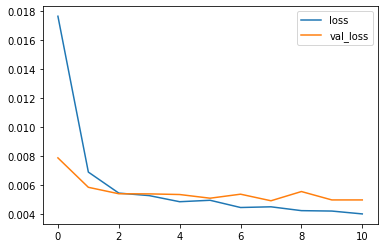

In [29]:
n_epochs = 1000 # don't care much about epochs since we use early stopping
batch=360
model.compile(optimizer='adam', loss='mse')
checkpointer = ModelCheckpoint(filepath="load_weather_model_48h.h5",
                               verbose=1,
                               save_best_only=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) # early stopping

history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=0,
                    callbacks=[checkpointer,es_callback])
df_loss = pd.DataFrame(history.history)
df_loss[['loss','val_loss']].plot()

In [30]:
predictions_train = model.predict(x_train)
predictions_test = model.predict(x_test)

predictions_train = scaler_label.inverse_transform(predictions_train)
y_train=scaler_label.inverse_transform(y_train)

predictions_test = scaler_label.inverse_transform(predictions_test)
y_test=scaler_label.inverse_transform(y_test)

trainScore = math.sqrt(mean_squared_error(y_train, predictions_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, predictions_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 435.37 RMSE
Test Score: 484.17 RMSE


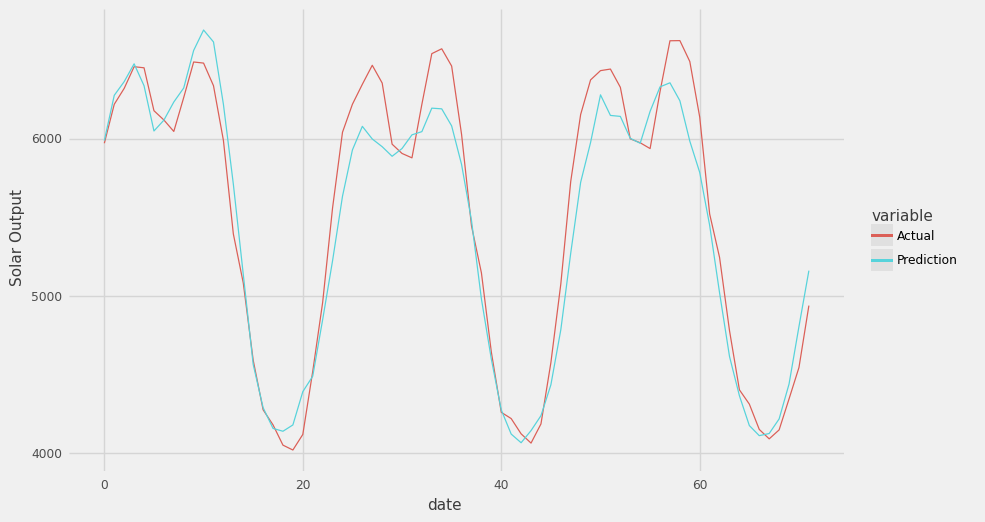

<ggplot: (-9223371926479930964)>


In [31]:
actualPred(y_test.reshape(-1,)[:72], predictions_test.reshape(-1)[:72])

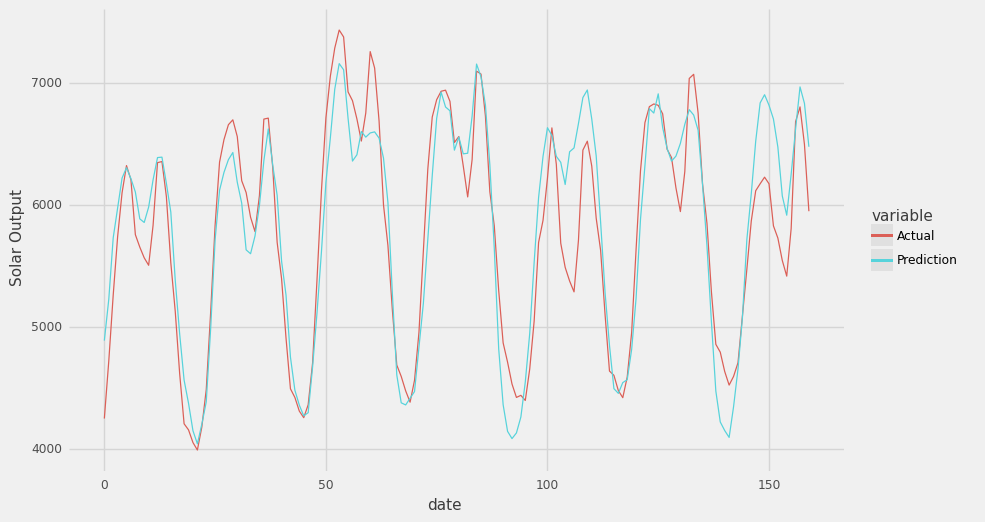

<ggplot: (-9223371926479927650)>


In [32]:
actualPred(y_test.reshape(-1,)[2950:3110], predictions_test.reshape(-1)[2950:3110])

We can see that incorporating weather and calendar data as additional input features can help in increasing the forecasting accuracy of the model. Nevertheless, further design work is required to achieve better results and better exploit the historical data we have.